In [30]:
import time
import os
from sklearn.model_selection import train_test_split
import cv2
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt

# Eigenface

In [31]:
def load_images_from_folder(folder_path, label, image_size=(325, 288)):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.jpg'):
            path = os.path.join(folder_path, filename)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(label)
    return images, labels

me_imgs, me_labels = load_images_from_folder('../../data/complex/me', label=0)
face_imgs, face_labels = load_images_from_folder('../../data/complex/images_of_face', label=1)

# Combine
all_images = me_imgs + face_imgs
all_labels = me_labels + face_labels


In [32]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.33, stratify=all_labels, random_state=42
)


In [33]:
def evaluate_model(model, images, labels, threshold):
    correct = false = unrecognized = 0
    confidences = []

    for img, true_label in zip(images, labels):
        predicted_label, confidence = model.predict(img)
        if confidence > threshold:
            unrecognized += 1
        elif predicted_label == true_label:
            correct += 1
            confidences.append(confidence)
        else:
            false += 1
            confidences.append(confidence)

    return correct, false, unrecognized, confidences


In [39]:
def run_eigenface_experiment(train_imgs, train_labels, test_imgs, test_labels, num_components_list, threshholds):
    results = []

    for num_components in num_components_list:
            for threshold in threshholds:
                model = cv2.face.EigenFaceRecognizer_create(num_components=num_components, threshold=threshold)
                model.train(train_imgs, np.array(train_labels))

                correct, false, unrecognized, confidences = evaluate_model(model, test_imgs, test_labels, threshold)

                result = {
                    "num_components": num_components,
                    "threshold": threshold,
                    "correct": correct,
                    "false": false,
                    "unrecognized": unrecognized,
                    "min_conf": np.min(confidences) if confidences else None,
                    "max_conf": np.max(confidences) if confidences else None,
                    "mean_conf": np.mean(confidences) if confidences else None,
                    "std_conf": st.stdev(confidences) if len(confidences) > 1 else None
                }
                results.append(result)

                print(result)

                # Save reconstructed eigenface image for visual reference
                if correct >= max(result['correct'] for result in results):  # save best so far
                    label_str = f"Eigenfaces_nc{num_components}"
                    sample_img = test_imgs[0]
                    predicted_label, _ = model.predict(sample_img)
                    result_img_path = f"{label_str}_prediction_label{predicted_label}.jpg"
                    cv2.imwrite(result_img_path, sample_img)

    return results


{'num_components': 80, 'threshold': 100000, 'correct': 98, 'false': 1, 'unrecognized': 0, 'min_conf': np.float64(165.7648999288598), 'max_conf': np.float64(12448.65896491142), 'mean_conf': np.float64(3965.2965971116023), 'std_conf': 3183.9313435946283}
{'num_components': 100, 'threshold': 100000, 'correct': 97, 'false': 2, 'unrecognized': 0, 'min_conf': np.float64(176.54564892197547), 'max_conf': np.float64(12595.383856416607), 'mean_conf': np.float64(4161.291149583259), 'std_conf': 3253.4836132459454}
{'num_components': 150, 'threshold': 100000, 'correct': 96, 'false': 3, 'unrecognized': 0, 'min_conf': np.float64(204.93453747528304), 'max_conf': np.float64(13069.263182148059), 'mean_conf': np.float64(4563.556241593501), 'std_conf': 3262.132757121054}
{'num_components': 200, 'threshold': 100000, 'correct': 96, 'false': 3, 'unrecognized': 0, 'min_conf': np.float64(224.11020040922662), 'max_conf': np.float64(13217.721239099134), 'mean_conf': np.float64(4707.261071796032), 'std_conf': 323

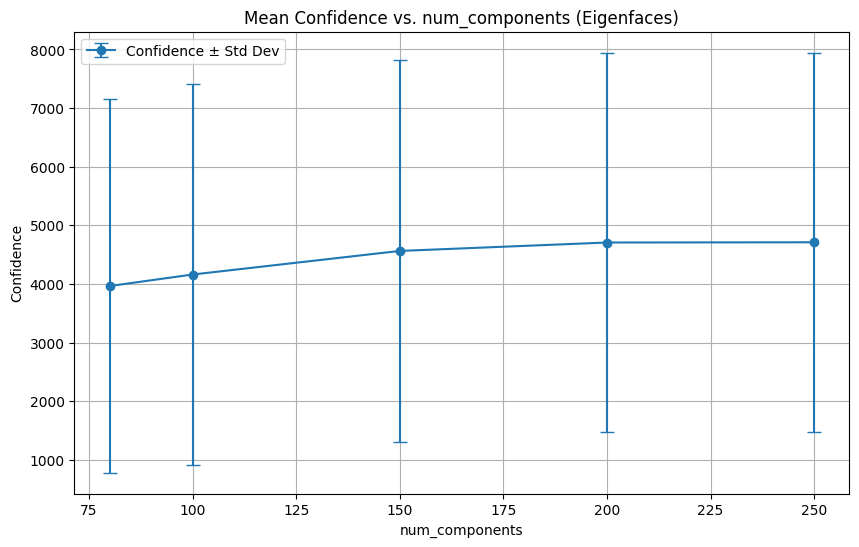

In [44]:
num_components_list = [80, 100, 150, 200, 250]
threshold_list = [100000]
results = run_eigenface_experiment(train_imgs, train_labels, test_imgs, test_labels, num_components_list, threshold_list)
df_results = pd.DataFrame(results)

# Plotting
x = [r['num_components'] for r in results]
y = [r['mean_conf'] for r in results]
yerr = [r['std_conf'] if r['std_conf'] is not None else 0 for r in results]

plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Confidence ± Std Dev')
plt.title('Mean Confidence vs. num_components (Eigenfaces)')
plt.xlabel('num_components')
plt.ylabel('Confidence')
plt.grid()
plt.legend()
plt.savefig("eigenfaces_confidence_vs_components.png")
plt.show()


{'num_components': 200, 'threshold': 5000, 'correct': 61, 'false': 0, 'unrecognized': 38, 'min_conf': np.float64(224.11020040922662), 'max_conf': np.float64(4896.417188890919), 'mean_conf': np.float64(2544.079749098387), 'std_conf': 1284.1650001515866}
{'num_components': 200, 'threshold': 20000, 'correct': 96, 'false': 3, 'unrecognized': 0, 'min_conf': np.float64(224.11020040922662), 'max_conf': np.float64(13217.721239099134), 'mean_conf': np.float64(4707.261071796032), 'std_conf': 3231.0240234077387}
{'num_components': 200, 'threshold': 50000, 'correct': 96, 'false': 3, 'unrecognized': 0, 'min_conf': np.float64(224.11020040922662), 'max_conf': np.float64(13217.721239099134), 'mean_conf': np.float64(4707.261071796032), 'std_conf': 3231.0240234077387}
{'num_components': 200, 'threshold': 100000, 'correct': 96, 'false': 3, 'unrecognized': 0, 'min_conf': np.float64(224.11020040922662), 'max_conf': np.float64(13217.721239099134), 'mean_conf': np.float64(4707.261071796032), 'std_conf': 3231

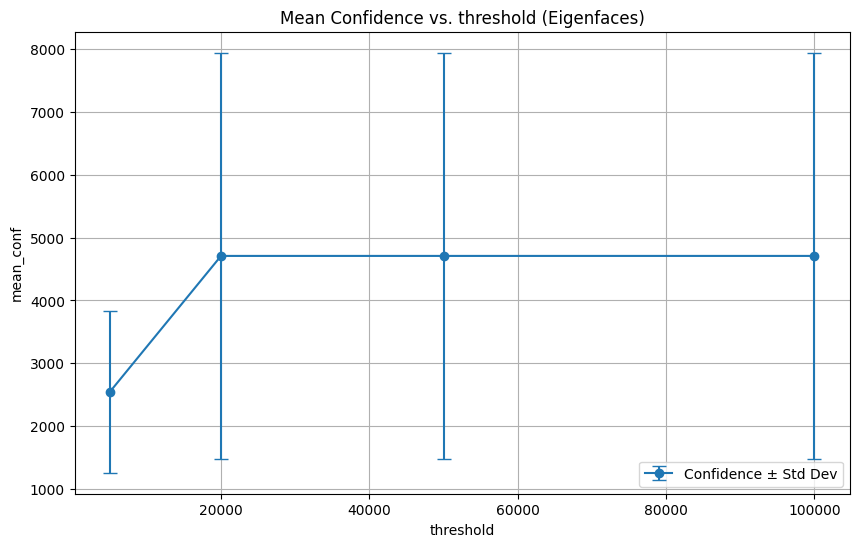

In [45]:
num_components_list = [200]
threshold_list = [5000, 20000, 50000, 100000]
results = run_eigenface_experiment(train_imgs, train_labels, test_imgs, test_labels, num_components_list, threshold_list)
df_results = pd.concat([df_results, pd.DataFrame(results)], axis=0)

# Plotting
x = [r['threshold'] for r in results]
y = [r['mean_conf'] for r in results]
yerr = [r['std_conf'] if r['std_conf'] is not None else 0 for r in results]

plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, label='Confidence ± Std Dev')
plt.title('Mean Confidence vs. threshold (Eigenfaces)')
plt.xlabel('threshold')
plt.ylabel('mean_conf')
plt.grid()
plt.legend()
plt.savefig("eigenfaces_confidence_vs_components.png")
plt.show()


In [46]:
df_results

,num_components,threshold,correct,false,unrecognized,min_conf,max_conf,mean_conf,std_conf
0,80,100000,98,1,0,165.764900,12448.658965,3965.296597,3183.931344
1,100,100000,97,2,0,176.545649,12595.383856,4161.291150,3253.483613
2,150,100000,96,3,0,204.934537,13069.263182,4563.556242,3262.132757
3,200,100000,96,3,0,224.110200,13217.721239,4707.261072,3231.024023
4,250,100000,96,3,0,224.289490,13217.807479,4711.320787,3232.664108
0,200,5000,61,0,38,224.110200,4896.417189,2544.079749,1284.165000
1,200,20000,96,3,0,224.110200,13217.721239,4707.261072,3231.024023
2,200,50000,96,3,0,224.110200,13217.721239,4707.261072,3231.024023
3,200,100000,96,3,0,224.110200,13217.721239,4707.261072,3231.024023
